In [1]:
%load_ext autoreload
%matplotlib inline

import logging
import sys

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation
from scipy.spatial import procrustes
from scipy.linalg import orthogonal_procrustes

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image  

import hyperhyper as hy
import dataset
import math

/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
import logging
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

In [3]:
b = hy.Bunch(f'/mnt/data2/ptf/bunches/bi_2010_decay_de_2')

INFO:gensim.utils:loading Corpus object from /mnt/data2/ptf/bunches/bi_2010_decay_de_2/corpus.pkl
DEBUG:smart_open.smart_open_lib:{'transport_params': {}, 'ignore_ext': False, 'opener': None, 'closefd': True, 'newline': None, 'errors': None, 'encoding': None, 'buffering': -1, 'mode': 'rb', 'uri': '/mnt/data2/ptf/bunches/bi_2010_decay_de_2/corpus.pkl'}
INFO:gensim.utils:loading vocab recursively from /mnt/data2/ptf/bunches/bi_2010_decay_de_2/corpus.pkl.vocab.* with mmap=None
INFO:gensim.utils:loaded /mnt/data2/ptf/bunches/bi_2010_decay_de_2/corpus.pkl


/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [4]:
def get_best(year):
    b = hy.Bunch(f'/mnt/data2/ptf/bunches/bi_{year}_decay_4')
    db = dataset.connect(f'sqlite:////mnt/data2/ptf/bunches/bi_{year}_decay_4/results.db')
    statement = 'SELECT * FROM experiments where pair_args__dynamic_window="decay" ORDER BY micro_results DESC LIMIT 1'
    
    for best in list(db.query(statement)):
        oov = True if best['pair_args__delete_oov'] == 1 else False
        window = int(best['pair_args__window'])
        if not isinstance(window, int):
            window = int.from_bytes(window, "little")
        neg = float(best['neg'])
        if neg.is_integer():
            neg = int(neg)
        dim = int(best['dim'])
            
        print(oov, best)
        try:
            print(best['neg'])
            kv, res = b.svd(impl='scipy', evaluate=True, pair_args={'subsample': 'deter', 'subsample_factor': best['pair_args__subsample_factor'], 'delete_oov': True, 'decay_rate': best['pair_args__decay_rate'], 'window': window, 'dynamic_window': 'decay'}, neg=neg, eig=best['eig'], dim=dim, keyed_vector=True)
            print(res)
            print(best)
        except Exception as e:
            print(e)
    return kv

In [11]:
from matplotlib import rcParams
rcParams['font.family'] = 'lato'

In [16]:
def draw_image(w, kv):
    pca = PCA(n_components=2)
    scaler = MinMaxScaler()
    vecs = [(w, kv[w])]
    for name, _ in kv.most_similar(w):
        vecs.append((name, kv[name]))
    principalComponents = pca.fit_transform([x[1] for x in vecs])
    principalComponents = scaler.fit_transform(principalComponents)
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5)
    fig.patch.set_visible(False)
    ax.axis('off')

    ax.scatter(principalComponents[:, 0], principalComponents[:, 1], color='black')
    

    for i, txt in enumerate([x[0] for x in vecs]):
        x = principalComponents[i][0] + 0.02
        y = principalComponents[i][1] - 0.02
        ax.annotate(txt, (x, y), weight='regular')
    return fig


In [17]:
def get_most_similar(w, kv, num=10):
    names = [w]
    vecs = [kv[w]]
    for name, _ in kv.most_similar(w, topn=num + 10):
        names.append(name)
        vecs.append(kv[name])
    for idx, n in enumerate(names):
        for n2 in names:
            if n == n2:
                continue
            if n[:-1] == n2 and n[-1] in ('s', 'n'):
                del names[idx]
                del vecs[idx]
            
    return names[:num], vecs[:num]


def to_2d(vecs):
    pca = PCA(n_components=2)
    scaler = MinMaxScaler((-1, 1))
    points = pca.fit_transform(vecs)
    points = scaler.fit_transform(points)
    print(len(points))
    return points, [pca, scaler]

In [7]:
kvs = [get_best(year) for year in [2010, 2012, 2014, 2016, 2018]]

INFO:gensim.utils:loading Corpus object from /mnt/data2/ptf/bunches/bi_2010_decay_4/corpus.pkl
DEBUG:smart_open.smart_open_lib:{'transport_params': {}, 'ignore_ext': False, 'opener': None, 'closefd': True, 'newline': None, 'errors': None, 'encoding': None, 'buffering': -1, 'mode': 'rb', 'uri': '/mnt/data2/ptf/bunches/bi_2010_decay_4/corpus.pkl'}
INFO:gensim.utils:loading vocab recursively from /mnt/data2/ptf/bunches/bi_2010_decay_4/corpus.pkl.vocab.* with mmap=None
INFO:gensim.utils:loaded /mnt/data2/ptf/bunches/bi_2010_decay_4/corpus.pkl
True OrderedDict([('id', 320), ('method', 'svd'), ('impl', 'scipy'), ('pair_args__window', 10.0), ('pair_args__dynamic_window', 'decay'), ('pair_args__decay_rate', 0.33), ('pair_args__delete_oov', 1.0), ('pair_args__subsample', 'deter'), ('pair_args__subsample_factor', 7e-05), ('neg', 1.2999999999999998), ('eig', 0.35000000000000003), ('dim', 500.0), ('micro_results', 0.5486674539152988), ('macro_results', 0.6126339441738009), ('ws353rel_score', 0.650

/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


svd
k pair_args
{'micro': 0.5486674539152988, 'macro': 0.6126339441738009, 'results': [{'name': 'de_ws353rel', 'score': 0.6503565815779454, 'oov': 0.09126984126984126, 'fullscore': 0.5909986396085297}, {'name': 'de_schm280', 'score': 0.7243885580601162, 'oov': 0.09642857142857143, 'fullscore': 0.6545368042471764}, {'name': 'de_gur65', 'score': 0.6398429688717551, 'oov': 0.16923076923076924, 'fullscore': 0.5315618510626888}, {'name': 'de_simlex999', 'score': 0.3920119068931563, 'oov': 0.16016016016016016, 'fullscore': 0.3292272171004586}, {'name': 'de_gur350', 'score': 0.76170852511226, 'oov': 0.3057142857142857, 'fullscore': 0.5288433474350833}, {'name': 'de_ws353sim', 'score': 0.6373000544650776, 'oov': 0.11940298507462686, 'fullscore': 0.5612045255737251}, {'name': 'de_zg222', 'score': 0.4828290142362959, 'oov': 0.40540540540540543, 'fullscore': 0.28708752197833803}]}
OrderedDict([('id', 320), ('method', 'svd'), ('impl', 'scipy'), ('pair_args__window', 10.0), ('pair_args__dynamic_win

/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


svd
k pair_args
{'micro': 0.5433854673263544, 'macro': 0.6038202406445505, 'results': [{'name': 'de_ws353rel', 'score': 0.6515144519028375, 'oov': 0.09126984126984126, 'fullscore': 0.5920508312926579}, {'name': 'de_schm280', 'score': 0.7154801498472478, 'oov': 0.09642857142857143, 'fullscore': 0.6464874211119775}, {'name': 'de_gur65', 'score': 0.6088366904135839, 'oov': 0.16923076923076924, 'fullscore': 0.5058027889589773}, {'name': 'de_simlex999', 'score': 0.38762885571631345, 'oov': 0.15415415415415415, 'fullscore': 0.3278742573376225}, {'name': 'de_gur350', 'score': 0.7626136479221926, 'oov': 0.29428571428571426, 'fullscore': 0.5381873458193759}, {'name': 'de_ws353sim', 'score': 0.6252751666126037, 'oov': 0.1044776119402985, 'fullscore': 0.5599479103993467}, {'name': 'de_zg222', 'score': 0.4753927220970746, 'oov': 0.3963963963963964, 'fullscore': 0.28694876018472076}]}
OrderedDict([('id', 330), ('method', 'svd'), ('impl', 'scipy'), ('pair_args__window', 10.0), ('pair_args__dynamic_w

/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


svd
k pair_args
{'micro': 0.5532410838177457, 'macro': 0.6149709448276103, 'results': [{'name': 'de_ws353rel', 'score': 0.6436568079644545, 'oov': 0.0992063492063492, 'fullscore': 0.5798019659044887}, {'name': 'de_schm280', 'score': 0.6945799519584878, 'oov': 0.09642857142857143, 'fullscore': 0.6276025994482051}, {'name': 'de_gur65', 'score': 0.6740096992371795, 'oov': 0.18461538461538463, 'fullscore': 0.5495771393780079}, {'name': 'de_simlex999', 'score': 0.41084400023651335, 'oov': 0.15515515515515516, 'fullscore': 0.34709943563525253}, {'name': 'de_gur350', 'score': 0.7672382321171523, 'oov': 0.3142857142857143, 'fullscore': 0.5261062163089044}, {'name': 'de_ws353sim', 'score': 0.6467277016734382, 'oov': 0.1044776119402985, 'fullscore': 0.5791591358269595}, {'name': 'de_zg222', 'score': 0.46774022060604553, 'oov': 0.4369369369369369, 'fullscore': 0.2633672413322329}]}
OrderedDict([('id', 128), ('method', 'svd'), ('impl', 'scipy'), ('pair_args__window', 10.0), ('pair_args__dynamic_wi

/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


ERROR:sqlalchemy.pool.impl.StaticPool:Exception during reset or similar
Traceback (most recent call last):
  File "/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/sqlalchemy/pool/base.py", line 680, in _finalize_fairy
    fairy._reset(pool)
  File "/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/sqlalchemy/pool/base.py", line 867, in _reset
    pool._dialect.do_rollback(self)
  File "/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/sqlalchemy/engine/default.py", line 500, in do_rollback
    dbapi_connection.rollback()
sqlite3.ProgrammingError: SQLite objects created in a thread can only be used in that same thread. The object was created in thread id 139791799646016 and this is thread id 139790321202944.
ERROR:sqlalchemy.pool.impl.StaticPool:Exception closing connection <sqlite3.Connection object at 0x7f23761b2e30>
Traceback (most recent call last):
  File "/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/sqlalch

/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/filter/anaconda3/envs/hyperhyper/lib/python3.6/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


svd
k pair_args
{'micro': 0.5861612384644349, 'macro': 0.6589462986701539, 'results': [{'name': 'de_ws353rel', 'score': 0.6659501260341844, 'oov': 0.1111111111111111, 'fullscore': 0.5919556675859416}, {'name': 'de_schm280', 'score': 0.7371901448318878, 'oov': 0.1, 'fullscore': 0.6634711303486991}, {'name': 'de_gur65', 'score': 0.7593296483421733, 'oov': 0.16923076923076924, 'fullscore': 0.6308277078534977}, {'name': 'de_simlex999', 'score': 0.4353699383348946, 'oov': 0.15215215215215216, 'fullscore': 0.36912746523489065}, {'name': 'de_gur350', 'score': 0.8020749288246197, 'oov': 0.3171428571428571, 'fullscore': 0.547702594254526}, {'name': 'de_ws353sim', 'score': 0.7162165198109804, 'oov': 0.12935323383084577, 'fullscore': 0.6235715968503561}, {'name': 'de_zg222', 'score': 0.49649278451233714, 'oov': 0.4009009009009009, 'fullscore': 0.2974483799105443}]}
OrderedDict([('id', 28), ('method', 'svd'), ('impl', 'scipy'), ('pair_args__window', 10.0), ('pair_args__dynamic_window', 'decay'), (

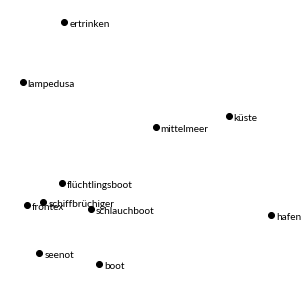

In [23]:
i = draw_image('mittelmeer', kvs[1])

In [24]:
i.savefig('2.svg')

In [192]:
# kvs = [kv1, kv2, kv3, kv4]

In [210]:
def align(m1, m2, names1, names2):
    m1_reordered = []
    for idx2, n2 in enumerate(names2):
        if n2 in names1:
            idx1 = names1.index(n2)
            m1_reordered.append(m1[idx1])
        else:
            m1_reordered.append(np.zeros(2))
    _,m, score = procrustes(m1_reordered, m2)
    sc = MinMaxScaler((-1, 1))
    m = sc.fit_transform(m)
    print(score)
    return m

In [211]:
def align_orth(m1, m2, names1, names2):
    m1_reordered = []
    m2_reordered = []
    for idx2, n2 in enumerate(names2):
        if n2 in names1:
            idx1 = names1.index(n2)
            m1_reordered.append(m1[idx1])
            m2_reordered.append(m2[idx2])
    transformation_matrix, score = orthogonal_procrustes(m2_reordered, m1_reordered)
#     print(score)
    m = m2.dot(transformation_matrix)
    sc = MinMaxScaler((-1, 1))
    m = sc.fit_transform(m)
    return m

In [212]:
def to_length(a):
    # push points out
    a = np.array(a)
    cof = 3/np.linalg.norm(a)
    return a * cof

In [213]:
# kvs = kvs[:3]

In [214]:
def get_location_for_missing_next():
    pass

In [215]:
def get_all(words, kv):
    return words, [kv[w] for w in words]

In [216]:
def get_settings(w, words=None):
    
    if not words is None:
        ps = [get_all(words, kv) for kv in kvs]
    else:
    # raw
        ps = [get_most_similar(w, kv, 10) for kv in kvs]

    transformed_points = []
    next_points = []
    transformers = []
    names = []

    for i in range(len(ps)):
        p = ps[i]
        names.append(p[0])
        tp, tr = to_2d(p[1])

        if i > 0:
            tp = align_orth(transformed_points[-1], tp, names[i - 1], names[i])

        transformed_points.append(tp)
        transformers.append(tr)

    for i in range(len(ps) - 1):
        set_net_p = []
        #         for name in names[i]:
        #             if name in kvs[i + 1]:
        #                 value = kvs[i + 1][name]
        #                 pca, scaler =  transformers[i + 1]
        #                 value  = scaler.transform(pca.transform([value]))[0]

        #             else:
        #                 value = np.array([-2, -2])
        #             set_net_p.append(value)
        #         next_points.append(set_net_p)

        for n_idx, name in enumerate(names[i]):
            if name in names[i + 1]:
                value = transformed_points[i + 1][names[i + 1].index(name)]
            else:
                value = to_length(transformed_points[i][n_idx])
            set_net_p.append(value)
        next_points.append(set_net_p)

    next_points.append(transformed_points[-1])
    
    # insert the points that will appear in the next scene to current scne
    # because we are iterating over the names, add the names after the main loops
    names_to_add = []
    for i in range(1, len(ps)):
        new_names = []
        for n_idx, n in enumerate(names[i]):
            if not n in names[i - 1]:
                new_names.append(n)
                transformed_points[i - 1] = np.concatenate(
                    (
                        transformed_points[i - 1],
                        np.asarray([to_length(transformed_points[i][n_idx])]),
                    ),
                    axis=0,
                )
                next_points[i - 1] = np.concatenate(
                    (next_points[i - 1], np.asarray([transformed_points[i][n_idx]])),
                    axis=0,
                )
        names_to_add.append(new_names)
    
    # add the new names here
    for i, n in enumerate(names_to_add):
        names[i] += n

    return names, transformed_points, next_points



In [217]:
def get_anim(names, cur_points, next_points):
    num_settings = len(names)
    fig, ax = plt.subplots()
    ax.set_xlim((-1.2, 1.2))
    ax.set_ylim((-1.2, 1.2))
    fig.set_size_inches(5, 5)

    scat = ax.scatter([], [])

    ans = []
    for n in names[0]:
        ans.append(ax.annotate("", xy=(0, 0)))

    year = ax.annotate("", xy=(0.7, -1.2))

    def init():
        print("init")
        scat.set_offsets(cur_points[0])

        for n in names[0]:
            ans.append(ax.annotate("", xy=(0, 0)))

        return (scat, year, *ans)

    # animation function.  This is called sequentially
    def animate(t):
        #         t /= 2
        cur_set = math.floor(t)
        t -= cur_set
        if t > 0.5:
            t -= 0.5
            t *= 2
            interpolation = (
                np.array(cur_points[cur_set]) * (1 - t)
                + np.array(next_points[cur_set]) * t
            )
        else:
            interpolation = cur_points[cur_set]
            
        year.set_text(str(2010 + cur_set * 2) + '/' + str(2011 + cur_set * 2))

        # clear old scatter points
        interpolation = np.concatenate((interpolation, np.ones((20, 2)) + 10), axis=0)
        scat.set_offsets(interpolation)

        updated_idx = 0
        for idx, n in enumerate(names[cur_set]):
            updated_idx += 1
            ans[idx].set_position(interpolation[idx] + (0.03, -0.025))
            ans[idx].set_text(n)

        # clear old annotations
        while updated_idx < len(ans):
            ans[updated_idx].set_text("")
            updated_idx += 1
        #             del ans[updated_idx]

        return (scat, year, *ans)

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(
        fig,
        animate,
        init_func=init,
        frames=np.arange(0, num_settings, 0.01),
        interval=60,
        blit=True,
    )
    return anim

In [242]:
s = get_settings('migrant', words=['deutscher', 'syrier', 'flüchtling', 'migrant', 'asylant', 'faulenzer', 'straftäter', 'ausländer', 'vergewaltiger', 'mörder', 'feigling'])

11
11
11
11
11


In [275]:
s = get_settings('migrant', words=['merkel', 'mutti', 'abschiebung', 'grenze', 'zaun', 'angie', 'verbrecher'] + ['deutscher', 'syrier', 'flüchtling', 'migrant', 'asylant', 'faulenzer', 'straftäter', 'ausländer', 'vergewaltiger', 'mörder', 'feigling'])

18
18
18
18
18


In [319]:
s = get_settings('grüne', words=['berlin', 'london', 'paris', 'washington', 'athen', 'madrid', 'wien', 'kopenhagen', 'oslo'])

9
9
9
9
9


In [327]:
s = get_settings('grüne', words=['merkel', 'seehofer', 'gabriel', 'roth', 'trittin', 'wagenknecht', 'gysi'])

7
7
7
7
7


In [331]:
s = get_settings('mittelmeer')

10
10
10
10
10


init


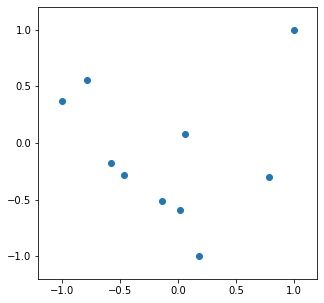

In [332]:
a = get_anim(*s)

In [333]:
a

In [334]:
HTML(a.to_html5_video())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
DEBUG:matplotlib.animation:frame size in pixels is 360 x 360
INFO:matplotlib.animation:MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '360x360', '-pix_fmt', 'rgba', '-r', '16.666666666666668', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/tmp/tmpu96md3ch/temp.m4v']
init
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter.grab_frame: Grabbing frame.
DEBUG:matplotlib.animation:MovieWriter